In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 dataset preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Load pre-trained ResNet50 model
base_model = models.resnet50(pretrained=True)

# Freeze the layers of the base model
for param in base_model.parameters():
    param.requires_grad = False

# Modify the classifier for CIFAR-10 (10 classes)
num_features = base_model.fc.in_features
base_model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 10)
)

base_model = base_model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.fc.parameters(), lr=0.001)

# Training the model
def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    print("Training complete.")
    return model

# Train and save weights
trained_model = train_model(base_model, criterion, optimizer, train_loader, num_epochs=10)
torch.save(trained_model.state_dict(), "cifar10_transfer_learning_weights.pth")
print("Model weights saved successfully.")

# Load weights and evaluate
def evaluate_model(model, test_loader):
    model.eval()
    model.load_state_dict(torch.load("cifar10_transfer_learning_weights.pth"))
    model = model.to(device)
    print("Model weights loaded successfully.")

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate the loaded model
evaluate_model(base_model, test_loader)

# Perform predictions
def predict_sample(model, test_loader):
    model.eval()
    model.load_state_dict(torch.load("cifar10_transfer_learning_weights.pth"))
    model = model.to(device)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            print("Predicted:", predicted[:5].cpu().numpy())
            print("True Labels:", labels[:5].cpu().numpy())
            break

predict_sample(base_model, test_loader)

Files already downloaded and verified
Files already downloaded and verified


d:\Installed-Softwares\Anaconda\envs\gpu_torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Installed-Softwares\Anaconda\envs\gpu_torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 1.6988, Accuracy: 0.3996
Epoch [2/10], Loss: 1.5618, Accuracy: 0.4474
Epoch [3/10], Loss: 1.5267, Accuracy: 0.4608
Epoch [4/10], Loss: 1.4977, Accuracy: 0.4737
Epoch [5/10], Loss: 1.4867, Accuracy: 0.4755
Epoch [6/10], Loss: 1.4632, Accuracy: 0.4832
Epoch [7/10], Loss: 1.4466, Accuracy: 0.4884
Epoch [8/10], Loss: 1.4371, Accuracy: 0.4969
Epoch [9/10], Loss: 1.4259, Accuracy: 0.4975
Epoch [10/10], Loss: 1.4233, Accuracy: 0.4985
Training complete.
Model weights saved successfully.
Model weights loaded successfully.


C:\Users\naman\AppData\Local\Temp\ipykernel_29972\2376719608.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cifar10_transfer_learning

Test Accuracy: 0.5308


C:\Users\naman\AppData\Local\Temp\ipykernel_29972\2376719608.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cifar10_transfer_learnin

Predicted: [5 8 9 0 6]
True Labels: [3 8 8 0 6]


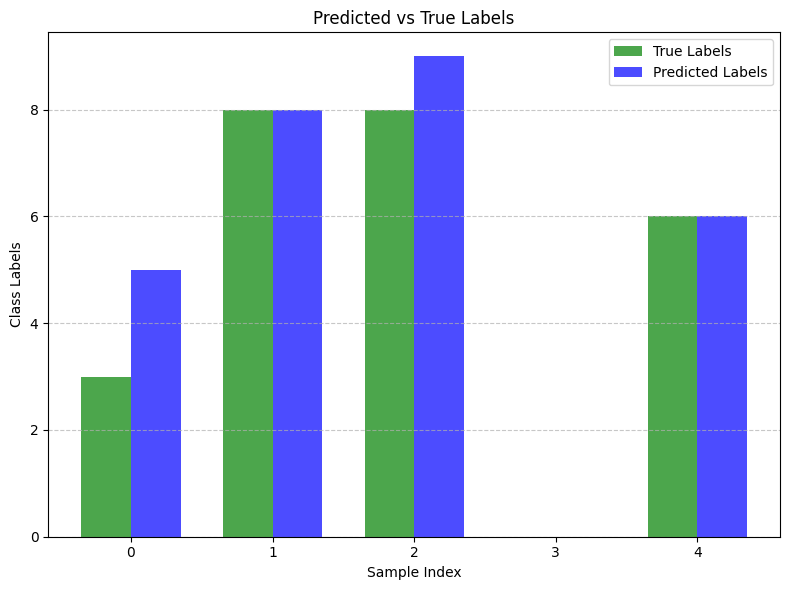

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Predicted and True Labels
predicted = [5, 8, 9, 0, 6]
true_labels = [3, 8, 8, 0, 6]

# Plotting predicted vs true labels
def plot_predictions(predicted, true_labels):
    x = np.arange(len(predicted))  # Number of samples (indices)
    width = 0.35  # Bar width

    plt.figure(figsize=(8, 6))

    # Bar chart for true and predicted labels
    plt.bar(x - width/2, true_labels, width, label='True Labels', color='green', alpha=0.7)
    plt.bar(x + width/2, predicted, width, label='Predicted Labels', color='blue', alpha=0.7)

    # Labeling the plot
    plt.title('Predicted vs True Labels')
    plt.xlabel('Sample Index')
    plt.ylabel('Class Labels')
    plt.xticks(x)
    plt.legend()

    # Adding grid for better visibility
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show plot
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_predictions(predicted, true_labels)
